# Analysis of U.S. Internship Postings on Indeed.com - A Web Scraping and pandas project

Nearly ten years ago, Ross Perlin, author of *Intern Nation: How to Earn Nothing and Learn Little in the Brave New Economy*, estimated that U.S. employers hire for 1.5 million internships each year, and that approximately half of those internships are unpaid. More recently, in 2016, the National Association of Colleges and Employers (NACE) estimated that [around 60% of U.S. interns are paid, with most unpaid opportunities coming from social service fields](https://sites.sju.edu/careers/files/the-impact-of-unpaid-internships-on-career-development.pdf). NACE research on the topic of U.S. internships has also revealed that [college students who complete paid internships have far more favorable post-college employment outcomes than those who only complete unpaid internships](https://www.theatlantic.com/business/archive/2013/06/do-unpaid-internships-lead-to-jobs-not-for-college-students/276959/). In addition to offering interns less resume-building value than paid opportunities do, there are enduring concerns about the [equity](https://www.usnews.com/opinion/knowledge-bank/articles/2016-04-04/education-or-exploitation-should-all-internships-be-paid) and [legality](https://www.shrm.org/resourcesandtools/legal-and-compliance/employment-law/pages/is-your-unpaid-internship-program-legal.aspx) of unpaid internships. 

Despite all of this, unpaid internships still abound in the U.S. For this project, I set out to look at a snapshot of internship listings (posted within the last week of April 2021) on the popular job search engine Indeed.com. I was interested in exploring the following questions:

* What percentage of internship opportunities currently listed on Indeed are paid positions?
* Among the paid internship opportunities on Indeed, what are the pay rates like?
* Geographically, where are paid internships concentrated?
* Are certain industries more likely to pay their interns than others?

I hypothesized (before reading the 2016 report from NACE) that only about 20% of internship postings would be paid opportunities, that most paid opportunities would offer around $15 per hour, that paid opportunities would be concentrated in urban areas with high costs of living (NYC, the Bay Area, Chicago, and D.C), and that most of the paid opportunities would be in the fields of web development/engineering and finance. I backed away from the industry-related inquiry after realizing that, in this time of social distancing, it appears that the industries hiring interns right now are mostly ones where remote work is possible. For example, Indeed's Hiring Lab recently reported that [the percentage all marketing internships that offer remote work jumped from 14.3\% to 45.3\% during the pandemic](https://www.hiringlab.org/2021/04/27/remote-internships-jump-during-pandemic/).

## Step 1: Getting the Data (web scraping with BeautifulSoup)

The first step of this project was to use BeautifulSoup to collect the results of a search on Indeed.com for "intern" postings in the U.S. This step was extremely time consuming because 1) connecting with Indeed.com to run a web-scraping program tends to trigger captcha checkpoints on Indeed's end that disrupt the program and 2) many postings on Indeed are reposted within a short timeframe, so there were *many* duplicate records in the original version of the dataset. 

To deal with the captcha roadblocks, I incorporated Python's `time` module to add a 2-second pause between iterations of the web scraping loop. In order to get enough unique records for analysis, I ran multiple calls of the `parse_web_data` function on multiple days in the last week of April. Some of my successful attempts to run this function took hours, because of the extra time built into the function itself as well as the high volume of webpages scraped. This function ultimately exports the scraped data to a csv file so that the data can be quickly imported for analysis later and the web scraping function does not need to be run again. After exporting this data to multiple csv files, I imported them back into Python and combined them. 

In [12]:
from bs4 import BeautifulSoup
import requests 
import time
import numpy as np
import pandas as pd
import csv

def extract_web_data(pagenum):
    """extracts and returns a single webpage of prespecified search criteria on Indeed.com"""
    # scrape customized search for job postings where the title contains the word "intern," posted any time, located
    # in the U.S., given the page number of the search results as a parameter. 
    site_req = requests.get('https://www.indeed.com/jobs?q=title%3Aintern&l=United+States&start={pagenum}') 
    indeed_soup = BeautifulSoup(site_req.content, 'html.parser')
    return indeed_soup


In [ ]:
def parse_web_data(): 
    """calls the previous function to loop through multiple pages of Indeed search data, parsing through the results
    and ultimately appending that data to a list"""
    # initialize an empty list to hold the webpage data from each of the first 200 pages of search results 
    #page_list = []
    # initialize an empty list to hold just the essential data from each job posting for the dataset we're creating
    job_list = []
    # loop through the first 200 pages of search results, calling the extract_web_data function on each to get the soup
    for num in range (30000,40000,10):
        soup = extract_web_data(num)
        # to avoid being interrupted by 'captcha' security checks, I added a 2-second pause between iterations, which
        # dramatically slows down the process but does seem to have increased by scraping success rate!
        time.sleep(2)
        divs = soup.find_all('div', class_ = 'jobsearch-SerpJobCard')
        for item in divs:
            # loop through each job posting to grab the job title, company name, and location
            title = item.find('a').text.strip()
            company = item.find('span', class_ = 'company').text.strip()
            location = item.find('div', class_ = 'recJobLoc').get('data-rc-loc')
            # last, grab salary information from the job posting ONLY IF it exists
            try:
                salary = item.find('span', class_ = 'salaryText').text.strip()
            except: 
                salary = ''
            # create a list of dictionaries to hold the job listing data 
            job_dict = {'title': title, 'company': company, 'location': location, 'salary': salary}
            job_list.append(job_dict)
    # return the list of dictionaries
    return job_list

In [8]:
def get_job_dataframe():
    """calls the previous function and converts the job data to a pandas dataframe"""
    job_data = parse_web_data()
    df = pd.DataFrame(job_data)
    return df

def webdata_to_csv():
    """calls the function that creates a pandas dataframe of the Indeed data, then writes that data to a csv"""
    df = get_job_dataframe()
    df.to_csv('intern_listings_sample_10000.csv')

## Step 2: Cleaning and Normalizing the Data (pandas, lambdas, string methods, regex)

After running my web scraping function multiple times to get adequate data for this analysis, I used the pandas module to import the csv data files into pandas dataframes. The function below then concatenates all of the separate dataframes into one, and drops all duplicate records from the final dataframe. This left me with 511 unique records. Based on the total sample size of about 40,000 postings on Indeed.com during this timeframe, a sample size of 511 allows for a confidence level of 95% and a confidence interval of 5. Since so many of the 40,000 records seemed to be duplicates, the actual confidence level may be higher. 

In [55]:
import pandas as pd
import csv
def dedupe_data():
    """uses pandas functions to concatenate multiple datasets and drop all duplicate records from the dataset"""
    # read in multiple csv files from multiple web scraping calls and assign to local pandas dataframes
    raw_data_new = pd.read_csv("intern_listings_sample_20000_428.csv", index_col=0)
    raw_data_new2 = pd.read_csv("intern_listings_sample_10000.csv", index_col=0)
    df = pd.read_csv("intern_listings_sample_20000.csv", index_col=0)
    
    # store all local dataframes in a list
    datasets = [df, raw_data_new, raw_data_new2]
    
    # concatenate all three dataframes into one
    df = pd.concat(datasets)
    
    # run the drop_duplicates() function through each full row of the dataframe
    df = df.drop_duplicates(subset=['title','company','location','salary'])
    
    # export the final combined & deduplicated dataset to a csv for easy importing later
    df.to_csv('intern_dataset_dedupe_429.csv')
    

Once I had a full, deduplicated dataframe, the salary data needed to be normalized. The data includes records that list hourly, daily, weekly, monthly, and annual pay rates, so I needed to create a new column to hold this salary period data for subsetting by different timeframe categories later. There were also string and special character objects ($) in the salary column that needed to be removed so that the salary column can later be analyzed as numeric data. I also split the original "location" column into "city" and "state" columns to take a deeper look at location. 

In [2]:
import pandas as pd

def clean_data():
    """normalizes the dataset so that we can run more interesting analyses with it"""
    # import csv dataset created in the previous function and assign it to a local pandas dataframe
    intern_data = pd.read_csv("intern_dataset_dedupe_429.csv", index_col=0)
    
    # use string method to split the 'location' column into 2 new columns: 'city' and 'state'
    intern_data[['city','state']] = intern_data.location.str.split(",",expand=True)
    
    # use the same string method to split the 'salary' column into 2 new columns: 1 for the numeric values and 1 for
    # the pay period string data ('hour' ,'day', 'month', 'year')
    intern_data[['salary','salary_period']] = intern_data.salary.str.split(" an ", expand=True )
    intern_data[['salary','salary_period']] = intern_data.salary.str.split(" a ", expand=True )
    intern_df = (intern_data[['title', 'company', 'salary', 'salary_period', 'city', 'state']])
    
    # now, use pd.DataFrame.replace() function and regular expressions to remove all remaining non-numeric 
    # characters from the 'salary' column 
    intern_df = intern_df.replace(to_replace={'salary': {r'From':'', r'Up to':'', r'\$':'', r',':''}}, regex=True)
    
    # use str.split once again to deal with salary ranges: split into two temporary columns on the '-' character
    intern_df[['salary_min', 'salary_max']] = intern_df.salary.str.split("-", expand=True)
    intern_df = (intern_df[['title', 'company', 'salary_min', 'salary_max', 'salary_period', 'city', 'state']])
    # this video was extremely helpful when debugging the common pandas SettingWithCopy warning I got here: https://www.youtube.com/watch?v=4R4WsDJ-KVc
    
    # now, use exception handling to iterate through these two columns, calculating an average wage for all records
    # that included salary ranges
    try:
        intern_df['salary_min'] = intern_df.apply(lambda x,y: x['salary_min'] + y['salary_max']/ 2, axis=1)
    except:
        intern_df['salary_max'] = ''
    # salary_min now contains all of the normalized numeric data for all records with salary data. We can now drop 
    # the salary_max column and change the data type in salary_min from object to float64
    intern_df['salary_min'] = intern_df['salary_min'].astype(float)
    intern_df = (intern_df[['title', 'company', 'salary_min', 'salary_period', 'city', 'state']])
    intern_df.columns = ['title', 'company', 'salary', 'salary_period', 'city', 'state']
    
    # finally, fill in the null values in the 'salary' and 'salary_period' columns so that they can easily be filtered 
    # later
    intern_df['salary'].fillna(value=0, inplace=True)
    intern_df['salary_period'].fillna(value='None', inplace=True)

    return intern_df

clean_data()


,title,company,salary,salary_period,city,state
0,NaN,"Alteryx, Inc.",43.11,None,Broomfield,CO
1,Nursery and Plant Propagation Intern,Goodblend,0.00,None,Pittsburgh,PA
2,"Data Analytics, BI & Data Pipeline Intern",Cruz Street,0.00,None,Remote,None
3,Efficiency Study Intern,GREAT AMERICAN DELI,14.00,None,Ooltewah,TN
4,Intern *,Morgan Stanley,0.00,None,Walnut Creek,CA
...,...,...,...,...,...,...
5837,Information Technology Intern,The SoundSide Group,10.00,None,Plymouth,NC
5838,Intern - Finance,Midland States Bank,0.00,None,Effingham,IL
5841,UX/UI Design Intern,"Native Agtech, Inc.",15.00,None,Miami,FL
5844,"Intern, Dental Health Advocate",GEHA,0.00,None,Lee's Summit,MO


## Step 3: Analyzing the Data, at Long Last! (logical subsetting with pandas)

In [3]:
df = clean_data()

salary_subset = df[(df.salary > 0)]

salary_subset.shape

(222, 6)

^This quick check tells us that there are 222 internship records in the dataframe with salary information, about 43% of all records in the dataset, which is way higher than I originally hypothesized, but also much lower than the 60% reported by the National Association of Colleges and Employers in 2016. 

### Geographic Trends - All Internship Postings

In [4]:
def get_all_internships_geog():
    """reads in the normalized dataframe from the last function and counts occurrences of unique cities and states"""
    # store dataframe to local variable
    df = clean_data()
    
    # use value_counts and .head functions to get the top ten most frequently occurring cities and states
    top_states_all = pd.value_counts(df['state']).head(10)
    top_cities_all = pd.value_counts(df['city']).head(10)

    print("Most Frequently Occurring Cities: ")
    print(top_cities_all)
    print("")
    print("Most Frequently Occurring States: ")
    print(top_states_all)
    
get_all_internships_geog()


Most Frequently Occurring Cities: 
Remote           51
New York         18
Pittsburgh       13
Los Angeles       8
Milwaukee         8
Columbus          7
Austin            6
United States     6
Washington        5
St. Louis         5
Name: city, dtype: int64

Most Frequently Occurring States: 
 CA    56
 PA    39
 NY    32
 FL    22
 TX    22
 WI    21
 MO    20
 NC    19
 IL    19
 OH    16
Name: state, dtype: int64


Unsurprisingly, in the time of COVID, remote is by far the most commonly occurring location for internships!

### Geographic Trends - Paid Internship Postings

In [6]:
def get_paid_internships_geog():
    """reads in the normalized dataframe, creates a subset of the dataframe that includes only records with 
    salary data, and counts occurrences of unique cities and states"""
    # store dataframe to local variable
    df = clean_data()
    # create and store paid internship subset
    salary_subset = df[(df.salary > 0)]
    
    # use value_counts and .head functions to get the top ten most frequently occurring cities and states
    top_states = pd.value_counts(salary_subset['state']).head(10)
    top_cities = pd.value_counts(salary_subset['city']).head(10)
    
    print("Most Frequently Occurring Cities among Paid Internship Listings: ")
    print(top_cities)
    print("")
    print("Most Frequently Occurring States among Paid Internship Listings: ")
    print(top_states)

get_paid_internships_geog()

Most Frequently Occurring Cities among Paid Internship Listings: 
Remote         28
Los Angeles     5
New York        4
San Jose        4
Miami           4
Columbus        4
Troy            3
Lincoln         3
Pittsburgh      3
Fort Worth      3
Name: city, dtype: int64

Most Frequently Occurring States among Paid Internship Listings: 
 CA    25
 FL    14
 TX    12
 CO    12
 MI     9
 WI     9
 NY     9
 NC     7
 OH     7
 MO     6
Name: state, dtype: int64


Interestingly, more than half of all remote-based internships are paid opportunities! Additionally, it looks like about half of the records for several states (California, Texas, Florida, etc.) are remote opportunities as well. 
<br>
<br>
## Salary Offerings by Pay Period Category

In this section, I compared by findings to the current national averages reported by [Indeed](https://www.indeed.com/career/intern/salaries) and [ZipRecruiter](https://www.ziprecruiter.com/Salaries/Intern-Salary-per-Hour) for all U.S. internships. 

In [8]:
def get_annual_salaries():
    """subsets original dataframe and runs descriptive statistics for all records that list an annual salary"""
    df = clean_data()
    # store a subset of the data to a local variable
    per_year_subset = df[(df.salary_period == 'year')]
    # use .describe function to get the stats!
    return per_year_subset.describe()

get_annual_salaries()

,salary
count,37.000000
mean,42716.216216
std,11578.560492
min,15000.000000
25%,38000.000000
50%,43000.000000
75%,48000.000000
max,65000.000000


There are 37 intern postings in the dataframe with annual salaries reported. The mean and median salaries for this subset of postings are relatively close, at \\$42,716 and \\$43,000 respectively. This is significantly higher than the national average intern salary currently reported by ZipRecruiter (\\$31,255) as well as the national average reported by Indeed (\\$32,669).


In [4]:
def get_monthly_salaries():
    """subsets original dataframe and runs descriptive statistics for all records that list a monthly salary"""
    df = clean_data()
    # store a subset of the data to a local variable
    per_month_subset = df[(df.salary_period == 'month')]
    # use .describe function to get the stats!
    return per_month_subset.describe()
    

get_monthly_salaries()

,salary
count,11.000000
mean,1909.090909
std,1438.370290
min,1000.000000
25%,1000.000000
50%,1000.000000
75%,2600.000000
max,5500.000000


There are 11 intern postings in the dataframe with monthly salaries reported. Since the median and minimum are euqal, we know that half of these postings = \\$1,000. There is at least one outlier on the high end that is driving up the mean value to $1,900. The national averages reported by Indeed and ZipRecruiter is closer to the 3rd quartile of this data subset (\\$2,317 and \\$2,604). The above-average salaries in this subset are in the fields of machine learning, venture capital, industrial design & production, and sales. The lower salaries span a wide variety of fields, including marketing, human resources, project management, and various research opportunities with a DC-based think tank. 

In [142]:
def get_weekly_salaries():
    """subsets original dataframe and runs descriptive statistics for all records that list a weekly salary"""
    df = clean_data()
    # store a subset of the data to a local variable
    per_week_subset = df[(df.salary_period == 'week')]
    # use .describe function to get the stats!
    return per_week_subset.describe()

get_weekly_salaries()

,salary
count,1.0
mean,250.0
std,NaN
min,250.0
25%,250.0
50%,250.0
75%,250.0
max,250.0


In [143]:
def get_daily_salaries():
    """subsets original dataframe and runs descriptive statistics for all records that list a daily salary"""
    df = clean_data()
    # store a subset of the data to a local variable
    per_day_subset = df[(df.salary_period == 'day')]
    # use .describe function to get the stats!
    return per_day_subset.describe()

get_daily_salaries()

,salary
count,4.0
mean,130.0
std,0.0
min,130.0
25%,130.0
50%,130.0
75%,130.0
max,130.0


In [7]:
import csv

def get_hourly_salaries():
    """subsets original dataframe and runs descriptive statistics for all records that list an hourly wage"""
    df = clean_data()
    # 'hourly' is the default setting on Indeed postings, so 'hour' does not appear in our salary_period column. 
    # We can safely assume that anything without a 'salary_period' value that also has a value > 0 in 'salary'
    # is a posting with an hourly wage listed
    per_hour_subset = df[(df.salary_period == 'None') & (df.salary > 0)]
    return per_hour_subset.describe()

get_hourly_salaries()

,salary
count,169.000000
mean,15.519172
std,5.429523
min,7.250000
25%,12.000000
50%,15.000000
75%,17.000000
max,43.110000


The distribution of hourly wages in this subset of the dataframe is nearly normal—although as you'll see in the boxplot below, there are four upper-fence outlier cases. The median and mean are right around \\$15 per hour, which is higher than the national average reported by Indeed (\\$14.03) but right on par with the national average reported by ZipRecruiter (\\$15.03). 

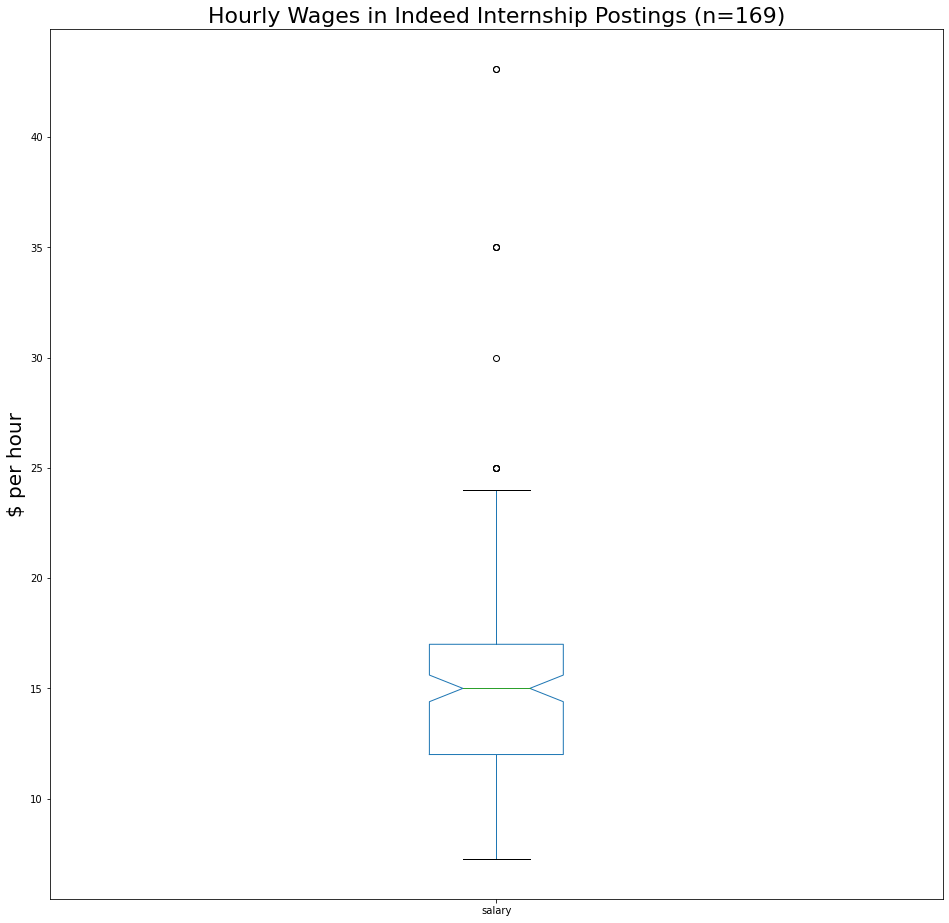

In [174]:
from matplotlib import pyplot as plt

def plot_hourly_wages():
    """subsets the original dataframe and creates a boxplot of all hourly wage data in the dataframe"""
    df = clean_data()
    # 'hourly' is the default setting on Indeed postings, so 'hour' does not appear in our salary_period column. 
    # We can safely assume that anything without a 'salary_period' value that also has a value > 0 in 'salary'
    # is a posting with an hourly wage listed
    per_hour_subset = df[(df.salary_period == 'None') & (df.salary > 0)]
    # adjust the figure size before specifying the plot you want
    plt.figure(figsize=(16,16))
    
    # use pandas indexing to specify one column of the dataframe for plotting
    per_hour_subset['salary'].plot(kind='box', notch=True)
    plt.ylabel('$ per hour', size=20)
    plt.title('Hourly Wages in Indeed Internship Postings (n=169)', size=22)

plot_hourly_wages()
    

## Step 4: Conclusions 

* Among 511 unique postings for internships featured on Indeed.com in the last week of April 2021, 43\% (222) were paid opportunities.
* Among the paid opportunities, more than half (67\%) offered an hourly wage ranging between \\$10 and \\$20. 
* About half of all remote-based internships posted to Indeed in this timeframe were paid opportunities. Additionally, about half of all internships in populous states like California, Texas, and Florida were paid. Remote-based positions were more likely to be paid than those based in any specific U.S. location. 
* Internships offering annual salaries had more variation in pay rate than those in any other salary period category, with a min of \\$15,000, a max of \\$65,000, and a stadard deviation of \\$11,578.  

### Limitations

* Around 45 records in the final dataset did not have job titles, so it is difficult to glean insights related to industry from these postings.
* While Indeed.com hosts tens of thousands of internship postings at any given time, there are other internship-specific search engines, like Handshake, which may be used by some employers instead of Indeed and that may prevent us from gaining a full picture of the current internship landscape from Indeed data alone. 
* Some industries may be underrepresented in this dataset as a result of the pandemic, during which many internship programs have been suspended (many involving work that cannot be accomplished on a remote basis). 

### Future Research

According to [a recent analytics report from Indeed](https://www.hiringlab.org/2021/04/27/remote-internships-jump-during-pandemic/), the rate of internship postings typically peaks in early April each year and slowly declines over the next few months. It would be interesting to scrape data over an earlier and longer timeframe in the spring to obtain a larger dataset for further analysis. It would also be interesting to compare which industries are represented among Indeed's internship postings right now compared to a year from now, when location-based internship programs may be reinvigorated. 